In [135]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt

import PyCodesDataProcessingBase.DataProceesingBase_GetBusNet as gbn
import PyCodesDataProcessingBase.DataProceesingBase_GetTrainNet as gtn
import PyCodesDataProcessingBase.DataProceesingBase_GetTransitVol as gtv
import PyCodesDataProcessingBase.DataProcessingBase_GetZonePop as gzp

In [129]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 8)
matplotlib.rcParams['lines.linewidth'] = 1
matplotlib.rcParams['lines.color'] = '#6495ED'
matplotlib.rcParams['lines.markeredgecolor'] = 'black'
matplotlib.rcParams['lines.markeredgewidth'] = 0
matplotlib.rcParams['lines.markerfacecolor'] = 'red'
matplotlib.rcParams['lines.markersize'] = 2

In [130]:
import importlib
# importlib.reload()
importlib.reload(gbn)
importlib.reload(gzp)
importlib.reload(gtv)

<module 'PyCodesDataProcessingBase.DataProceesingBase_GetTransitVol' from 'C:\\zhouweifile\\Transportation Data\\Singapore Geodatabase\\PyCodesDataProcessingBase\\DataProceesingBase_GetTransitVol.py'>

In [131]:
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

In [132]:
# Current Working Directory
os.chdir(r'C:\zhouweifile\Transportation Data\Singapore Geodatabase')
#
ROOT_PATH = r'C:\zhouweifile\Transportation Data\Singapore Geodatabase'

# 1. Bus information

The process of construct bus (transit) network


1. bus stop location geographical information

    There are two source:

    1. from datamall static datasets: 
    
        - **file type:** `shapefile`
        - **CRS:** EPSG:3414
        - **function:** `gbn.ReadBusStopLocShp()
            - **return:** `geopandas.GeoDataFrame`

    2. from datamall dynamic datasets (API): 
    
        - **file type:** `csv` 
        - **CRS:** GPS (EPGS:4326):
        - **function:** `gbn.ReadBusStopLocCsv()`: 
            - **return:** `geopandas.GeoDataFrame`
        
     3. combine the two source data
     
         - `gbn.BusStopLocUpdate(data1, data2)`
             - both `data1` and `data2` are `geopandas.GeoDataFrame`
             - columns: `['BusStopCode', 'Description', 'geometry']`



2. bus route list

    collected from datamall dynamic datasets (API). The `StopSequence` column can be used to infer the bus line.
    
    - **function:** `gbn.ReadBusRouteCsv()`
        - **return:** `pandas.DataFrame`


3. bus network

    According to bus stop and bus route to construct the bus network (**directed graph** `networkx.DiGraph()`)
    - the stop from 'route' table if not exist in `stop` table will be deleted.
    - the stop from 'stop' table if not exist in `route` table will also be deleted.
    - **function:** `gbn.BusStopRoute2Net(stop, route, multiedge=False)`
        - **multiedge**: `bool`
        - **return:** `networkx.DiGraph()` or `networkx.MultiDiGraph()`
        - `networkx.DiGraph()`
        - `networkx.MultiDiGraph()`


4. bus line

    Construct bus line shapefile (line layer), each line consists of a sequence of bus stop 
    - **function:** `gbn.Route2LineShp(bus_stop, bus_route)`

5. `Gephi`: stop (node) list, route (edge) list

    from bus network (`net`:`networkx.DiGraph()`) construct the stop (node) list and route (edge) list input into *Gephi*
    
    - **function:** `gbn.BusNet2NodeEgesPd(bus_net)`
        - **return:** `node_pd` and `edge_pd` (`pandas.DataFrame`)
    

## 1.1. Get Bus Stop Location

In [121]:
def BusStopLoc():
    
    # bus location from the shapefile
    path = os.path.join(ROOT_PATH, 'Public-Trainsit-Bus', 
        'Stop Location', 'Bus Stop Location (from datamall Static Datasets)',
        'BusStopLocation_Jan2022',  # 'BusStopLocation_Aug2021',
        'BusStop.shp'
    )
    stop_loc = gbn.ReadBusStopLocShp(path)  
    
    # bus location from the csv 
    path = os.path.join(ROOT_PATH, 'Public-Trainsit-Bus', 
        'Stop Location', 'Bus Stop Location (from datamall API)',
        'bus_stops_2021-12-21.csv'
    )
    stop_loc1 = gbn.ReadBusStopLocCsv(path)   
    # print(stop_loc.shape, stop_loc1.shape)
    
    # merge, drop depulicate
    stop_loc = gbn.BusStopLocUpdate(stop_loc, stop_loc1)
    
    return stop_loc
# ======================================================================


bus_stop = BusStopLoc()
display(bus_stop.head(5))

UNION_CRS = bus_stop

# save file
# bus_stop.to_file('GeoDatabase/shapefiles/bus_stop_loc/bus_stop_loc.shp')

,BusStopCode,Description,geometry
0,01012,HOTEL GRAND PACIFIC,POINT (30140.804 31031.951)
1,01013,ST JOSEPH'S CH,POINT (30218.752 31126.487)
2,01019,BRAS BASAH CPLX,POINT (30187.770 31034.554)
3,01029,OPP NATL LIB,POINT (30345.826 31007.645)
4,01039,BUGIS CUBE,POINT (30471.076 31175.633)


C:\Users\e0751551\.conda\envs\py37geo\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.


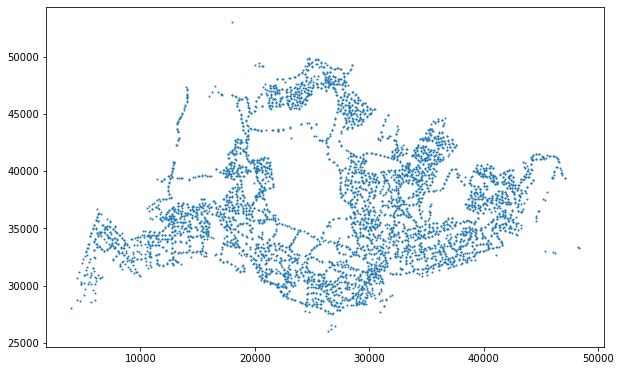

In [122]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1 = bus_stop_loc.plot(markersize=1, ax=ax1)

## 1.2. Construct Bus Network

### 1.2.1. Get Bus Route

In [123]:
# get bus route list csv file
path = os.path.join(ROOT_PATH, 'Public-Trainsit-Bus', 'Route',
    'Bus Route (from datamall API)',
    'bus_routes_2021-12-21',
    'bus_routes_2021-12-21.csv'
)

bus_route = gbn.ReadBusRouteCsv(path)  
display(bus_route.head(5))

# bus_route1 = bus_route.merge(right=bus_stop, on='BusStopCode', how='inner')
# display(bus_route1.shape, bus_route1.head(5))

,ServiceNo,Operator,Direction,StopSequence,BusStopCode,Distance
0,105,SBST,1,51,28659,24.1
1,105,SBST,1,52,28649,24.8
2,105,SBST,1,53,28639,25.1
3,105,SBST,1,54,28319,25.5
4,105,SBST,1,55,28449,25.8


### 1.2.2. Transform Bus Route to Network

In [124]:
bus_net = gbn.BusStopRoute2Net(bus_stop, bus_route)
bus_net = gbn.NetProcessing(bus_net)
print(len(bus_net.nodes), len(bus_net.edges))

# bus_net1 = gbn.BusStopRoute2Net(bus_stop, bus_route, multiedge=True)
# print(len(bus_net1.nodes), len(bus_net1.edges), bus_route.shape)

5047 7423
5047 25003 (25779, 6)


### 1.2.3. Construct Bus Line (shapefile)

In [125]:
# bus route to shapefile
bus_route_shp = gbn.Route2LineShp(bus_stop, bus_route)

# # save file
# bus_route_shp.to_file('GeoDatabase/shapefiles/bus_line/bus_line.shp')

C:\Users\e0751551\.conda\envs\py37geo\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  This is separate from the ipykernel package so we can avoid doing imports until


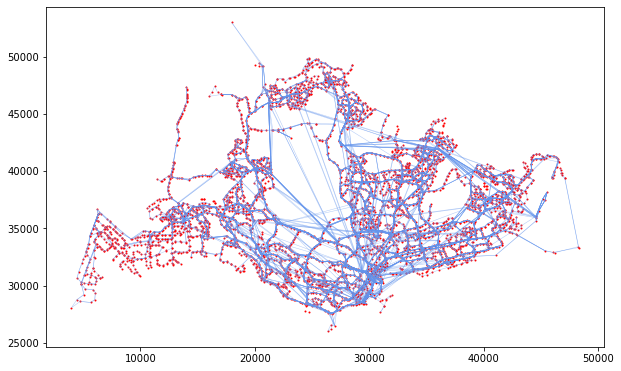

In [126]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1 = bus_route_shp.plot(lw=0.5, alpha=0.5, ax=ax1)
ax1 = bus_stop.plot(color='red', markersize=1, ax=ax1)

### 1.2.4. Construct the Node List and Edge List for *Gephi*

In [140]:
# bus network to node list and edge list, which are input to Gephi
node_pd, edge_pd = gbn.BusNet2NodeEgesPd(bus_net)
print(node_pd.shape, node_pd.head(5))
print(edge_pd.shape, edge_pd.head(5))

# # save file
# path = os.path.join(ROOT_PATH, 'Public-Trainsit-Bus', 'Gephi-BusNeworks')
# node_pd.to_csv(os.path.join(path, 'bus_network_node_list_2022-01-19.csv'), index=False)
# edge_pd.to_csv(os.path.join(path, 'bus_network_edge_list_2022-01-19.csv'), index=False)

(5047, 5)     Id       lat        lng    serv_num                      serv_li                     
0  28659  35182.395  18468.436     9                  105,188,NR5,333,502,52,657,990,188R
1  28649  35691.350  18278.082    11           41,188,188R,183,333,502,990,657,NR5,105,52
2  28639  35843.396  18063.435    11           990,657,52,502,188,333,188R,183,105,41,NR5
3  28319  35635.008  17804.038     7                             98M,98,52,41,183,176,105
4  28449  35403.314  17580.947    13     98M,105,160,98,52,990,506,49,176,41,334,160M,183
(7423, 5)   Source Target  dist serv_num                   serv_li                  
0  28659  28649   0.7     9            52,188R,188,333,657,NR5,990,105,502
1  28649  28639   0.3    11     52,183,188R,188,333,657,NR5,990,105,41,502
2  28639  28319   0.4     4                                  105,52,41,183
3  28639  28621   0.2     3                                   990,188R,188
4  28639  28321   0.4     4                                333,NR

## 1.3. Bus Stop Value

,IN_WD_0,IN_WD_1,IN_WD_10,IN_WD_11,IN_WD_12,...,IN_WD_total,IN_WE_total,OUT_WD_total,OUT_WE_total,BusStopCode
0,250.0,NaN,539.0,727.0,780.0,...,17087.0,6000.0,18822.0,6495.0,01012
1,43.0,NaN,272.0,340.0,460.0,...,11951.0,4084.0,6541.0,2194.0,01013
2,23.0,NaN,483.0,525.0,608.0,...,8465.0,2634.0,14607.0,4929.0,01019
3,83.0,NaN,637.0,828.0,1146.0,...,18195.0,6152.0,13635.0,4745.0,01029
4,306.0,NaN,813.0,1035.0,1362.0,...,27041.0,11607.0,27365.0,11473.0,01039


,IN_WD_0,IN_WD_1,IN_WD_10,IN_WD_11,IN_WD_12,...,OUT_WD_total,OUT_WE_total,BusStopCode,Description,geometry
0,250.0,NaN,539.0,727.0,780.0,...,18822.0,6495.0,01012,HOTEL GRAND PACIFIC,POINT (30140.804 31031.951)
1,43.0,NaN,272.0,340.0,460.0,...,6541.0,2194.0,01013,ST JOSEPH'S CH,POINT (30218.752 31126.487)
2,23.0,NaN,483.0,525.0,608.0,...,14607.0,4929.0,01019,BRAS BASAH CPLX,POINT (30187.770 31034.554)
3,83.0,NaN,637.0,828.0,1146.0,...,13635.0,4745.0,01029,OPP NATL LIB,POINT (30345.826 31007.645)
4,306.0,NaN,813.0,1035.0,1362.0,...,27365.0,11473.0,01039,BUGIS CUBE,POINT (30471.076 31175.633)


<class 'geopandas.geodataframe.GeoDataFrame'> (5170, 103)


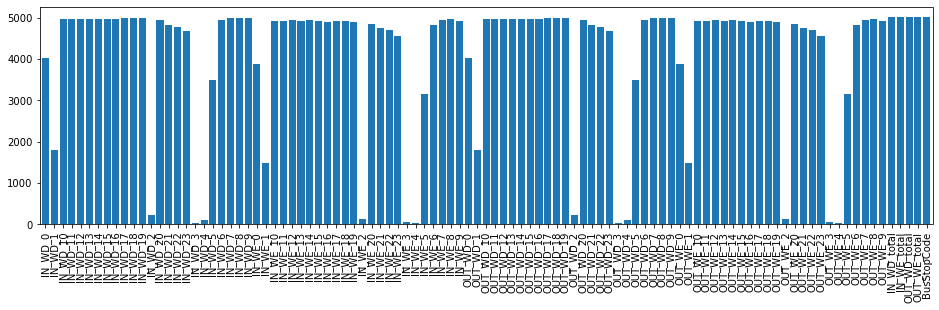

In [81]:
vol_date = '202112'
path = os.path.join(ROOT_PATH, 'Public-Trainsit-Bus', 'Volume', 
    'transport_node_bus_{0}'.format(vol_date[:4]),
    'transport_node_bus_{0}.csv'.format(vol_date)
)

bus_stop_vol = gtv.GetStopVol(path)
display(bus_stop_vol.head())
# explore the nan of bus_stop_vol
bus_stop_vol.notna().sum().plot(kind='bar', figsize=(16, 4), width=0.8)

bus_stop_vol = gtv.MergeStopVolLoc(bus_stop_vol, bus_stop_loc, merge_how='outer')
bus_stop_vol = gpd.GeoDataFrame(bus_stop_vol)

display(bus_stop_vol.head())
print(type(bus_stop_vol), bus_stop_vol.shape)

In [82]:
# bus_stop_vol.to_file('GeoDatabase/shapefiles/bus_stop_vol/bus_stop_vol_{0}.shp'.format(vol_date))

## 1.4. Bus Stop OD Passenger Trip

In [83]:
# data: year mouth
VOL_DATE = '202112'

path = os.path.join(ROOT_PATH, 'Public-Trainsit-Bus', 'Volume', 
    'origin_destination_bus_{0}'.format(VOL_DATE[:4]),
    'origin_destination_bus_{0}.csv'.format(VOL_DATE)
)

odtrip = gtv.GetODTrip(path)

display(odtrip.head(10), odtrip.shape)
# odtrip.info()
# allday (312326, 3)

,O_BusStopCode,D_BusStopCode,WD_0,WE_0,WD_1,...,WE_22,WD_23,WE_23,WD_total,WE_total
0,01012,01112,3.0,NaN,98.0,...,6.0,10.0,11.0,998.0,941.0
1,01012,01113,NaN,NaN,29.0,...,5.0,7.0,6.0,670.0,721.0
2,01012,01121,17.0,NaN,42.0,...,1.0,1.0,11.0,484.0,430.0
3,01012,01211,28.0,NaN,15.0,...,5.0,2.0,12.0,478.0,648.0
4,01012,01311,23.0,NaN,81.0,...,10.0,12.0,22.0,966.0,1042.0
5,01012,07371,1.0,NaN,1.0,...,NaN,1.0,4.0,33.0,37.0
6,01012,60011,NaN,NaN,6.0,...,NaN,NaN,NaN,82.0,38.0
7,01012,60021,NaN,NaN,4.0,...,NaN,NaN,NaN,46.0,36.0
8,01012,60031,7.0,NaN,7.0,...,4.0,3.0,7.0,276.0,489.0
9,01012,60159,1.0,NaN,NaN,...,NaN,NaN,NaN,85.0,125.0


(324763, 52)

### 1.4.2. Add OD Trip With Stop Location Info

In [8]:
odtrip_shp =  gtv.ODTrip2Shp(odtrip, bus_stop_loc)

# save to file
# odtrip_shp.to_file('GeoDatabase/shapefiles/bus_stop_vol_OD/bus_OD_{0}.shp'.format(VOL_DATE))

C:\Users\e0751551\.conda\envs\py37geo\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  


# 2. Train information

## 2.1. Get MRT Station Location

In [9]:
ROOT_PATH = r'C:\zhouweifile\Transportation Data\Singapore Geodatabase'
path = os.path.join(ROOT_PATH, 'Public-Trainsit-Train', 'Station Location', 
    'Station Location (from datamall Static Datasets)', 
    'TrainStation_Jan2022',
    'MRTLRTStnPtt.shp'
)

path = os.path.join(ROOT_PATH, 'Transport-Network', '[Citylines]Rail Networks', 
    '2022.01.23', 'shapefile', 'MRT_station.shp')

# path = os.path.join(ROOT_PATH, 'Public-Trainsit-Train', 'Station Location', 
#     'Station Location (from datamall Static Datasets)', 
#     'TrainStation_Jan2022',
#     'MRTLRTStnPtt.shp'
# )

train_sta_loc = gpd.read_file(path)
train_sta_loc = train_sta_loc.to_crs(UNION_CRS)

display(train_sta_loc.shape, train_sta_loc.head(5))

(164, 8)

,station,id,opening,buildstart,closure,line,system,geometry
0,Admiralty,18055,1996,1991,999999.0,North-South Line,SMRT Trains,POINT (24400.103 46923.089)
1,Aljunied,18072,1989,1985,999999.0,East-West Line,SMRT Trains,POINT (33516.819 33190.819)
2,Ang Mo Kio,17963,1987,1987,999999.0,North-South Line,SMRT Trains,POINT (29801.909 39120.901)
3,Bakau,18270,2003,2000,999999.0,Sengkang LRT line,SBS Transit,POINT (36027.295 41112.472)
4,Bangkit,18260,1999,1996,999999.0,Bukit Panjang LRT Line,SMRT Trains,POINT (21247.236 40225.625)


## 2.2. Get MRT Route Location

In [41]:
path = os.path.join(ROOT_PATH, 'Transport-Network', '[Citylines]Rail Networks', 
    '2022.01.23', 'shapefile', 'MRT_route.shp')

train_route_loc = gpd.read_file(path)
train_route_loc = train_route_loc.to_crs(UNION_CRS)

display(train_route_loc.head(5))

,start,end,line,system,geometry
0,18055,18054,North-South Line,SMRT Trains,"LINESTRING (24400.103 46923.089, 22875.496 464..."
1,18055,18056,North-South Line,SMRT Trains,"LINESTRING (24400.103 46923.089, 26520.079 478..."
2,18072,18210,East-West Line,SMRT Trains,"LINESTRING (33516.819 33190.819, 34593.550 333..."
3,18072,18071,East-West Line,SMRT Trains,"LINESTRING (33516.819 33190.819, 32232.537 326..."
4,17963,17962,North-South Line,SMRT Trains,"LINESTRING (29801.909 39120.901, 29293.317 404..."


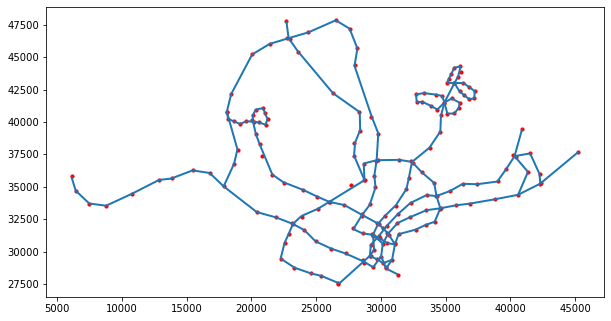

In [42]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(111)
ax1 = train_route_loc.plot(lw=2, alpha=1, ax=ax1)
ax1 = train_sta_loc.plot(color='red', markersize=10, ax=ax1)

## 2.3. MRT Station Volume

In [39]:
vol_date = '202112'
path = os.path.join(ROOT_PATH, 'Public-Trainsit-Train', 'Volume', 
    'transport_node_train_{0}'.format(vol_date[:4]),
    'transport_node_train_{0}.csv'.format(vol_date)
)

train_sta_vol = gtv.GetStopVol(path)
display(train_sta_vol.head(5))
print(train_sta_vol['BusStopCode'].unique().shape, train_sta_loc.shape)

,IN_WD_0,IN_WD_10,IN_WD_11,IN_WD_12,IN_WD_13,...,IN_WD_total,IN_WE_total,OUT_WD_total,OUT_WE_total,BusStopCode
0,0.0,3372.0,3151.0,3163.0,2944.0,...,58739.0,15034.0,62486.0,17459.0,BP10
1,NaN,3524.0,3346.0,3238.0,3001.0,...,61677.0,16128.0,49753.0,12897.0,BP11
2,NaN,2373.0,2521.0,2352.0,2287.0,...,42597.0,10113.0,31115.0,7519.0,BP12
3,0.0,1578.0,1537.0,1505.0,1324.0,...,27981.0,7070.0,17984.0,4242.0,BP13
4,NaN,3062.0,3107.0,2993.0,2626.0,...,54480.0,14713.0,42139.0,12347.0,BP2


(164,) (164, 8)


# 3. Zone information

## 3.1. Read Zone

In [ ]:
path = os.path.join(ROOT_PATH, 'Zones',
    'master-plan-2019-subzone-boundary-no-sea', 
    'master-plan-2019-subzone-boundary-no-sea-kml.kml'
)

# transform the CRS of zone
zone = gzp.ReadZoneShp(path).to_crs(bus_stop_loc.crs)
# print(zone.columns)

zone1 = zone.dissolve(by='PLN_AREA_C', as_index=False, aggfunc='first')
# 'SUBZONE_C', 'PLN_AREA_C', 'REGION_C'

display(zone.head())
display(zone1.head())

In [ ]:
# zone.to_file('GeoDatabase/shapefiles/zone/zone.shp')

fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(111)
ax1 = zone.plot(alpha=0.3, edgecolor='black', linewidth=1, ax=ax1)
ax1 = zone.centroid.plot(color='green', markersize=2, ax=ax1)

fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(111)
ax1 = zone1.plot(alpha=0.3, edgecolor='black', linewidth=1, ax=ax1)
ax1 = zone1.centroid.plot(color='green', markersize=2, ax=ax1)

## 3.2. Read Population

In [ ]:
path = os.path.join(ROOT_PATH, 'Populations',
    'singapore-residents-by-subzone-and-type-of-dwelling-2011-2019', 
    'planning-area-subzone-age-group-sex-and-type-of-dwelling-june-2011-2019.csv')
pop_raw = gzp.ReadZonePop(path)  

display(pop_raw.head())
# check SUBZONE_N and PLN_AREA_N column categorical values
# of pop_raw and zone whether are identical
gzp.CheckPopAndZoneMatch(pop_raw, zone)

pop = gzp.PopExtract(pop_raw, attrib='type_of_dwelling', zone_level='SUBZONE_N', year='2019')
pop1 = gzp.PopExtract(pop_raw, attrib='year', zone_level='PLN_AREA_N')
display(pop.head())
display(pop1.head())

## 3.3. Merge Zone and Population

In [ ]:
zone_pop = gzp.ZoneAddPop(zone, pop, zone_level='SUBZONE_N')
zone_pop1 = gzp.ZoneAddPop(zone1, pop1, zone_level='PLN_AREA_N')

display(zone_pop.head())
display(zone_pop1.head())

print(zone_pop.shape, zone_pop1.shape)


'''
# save file
pop = gzp.PopExtract(pop_raw, attrib='year', zone_level='SUBZONE_N')
pop = gzp.ZoneAddPop(zone, pop, zone_level='SUBZONE_N')
pop.to_file('GeoDatabase/shapefiles/population/population_by_year.shp')

pop = gzp.PopExtract(pop_raw, attrib='type_of_dwelling', zone_level='SUBZONE_N', year='2019')
pop = gzp.ZoneAddPop(zone, pop, zone_level='SUBZONE_N')
pop.to_file('GeoDatabase/shapefiles/population/population_by_type_2019.shp')

pop = gzp.PopExtract(pop_raw, attrib='sex', zone_level='SUBZONE_N', year='2019')
pop = gzp.ZoneAddPop(zone, pop, zone_level='SUBZONE_N')
pop.to_file('GeoDatabase/shapefiles/population/population_by_sex_2019.shp')

pop = gzp.PopExtract(pop_raw, attrib='age_group', zone_level='SUBZONE_N', year='2019')
pop = gzp.ZoneAddPop(zone, pop, zone_level='SUBZONE_N')
pop.to_file('GeoDatabase/shapefiles/population/population_by_age_2019.shp')
'''

In [ ]:
data = zone_pop
col = 'total'

fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(111)

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)

ax1 = data.plot(col, 
    alpha=0.3, edgecolor='black', linewidth=1, ax=ax1, 
    vmax=data[col].max(), vmin=data[col].min(),
    # cmap='cool', 
    legend=True, cax=cax
)